## **DCGAN: Deep Convolutional Generative Adversarial Networks**

Caso queira revisar a implementação veja esse post: [Understanding DCGANs: Deep Convolutional Generative Adversarial Networks
](https://medium.com/@danushidk507/understanding-dcgans-deep-convolutional-generative-adversarial-networks-1984bc028bf8)

*Tarefa*: Treinar e testar a GAN com districuições diferentes para Z~p(z). Vamos usar essas combinações:

| **$Z_{Train}$** | **$Z_{Test}$** |
| :-------------: | :------------: |
|      normal     |     uniform    |
|      normal     |     weibull    |
|     uniform     |     normal     |
|     uniform     |     weibull    |
|     weibull     |     normal     |
|     weibull     |     uniform    |
|      normal     |     uniform    |
|      normal     |     weibull    |
|     uniform     |     normal     |
|     uniform     |     weibull    |
|     weibull     |     normal     |


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import imageio.v2 as imageio

import time
import numpy as np
import os
from tqdm import tqdm

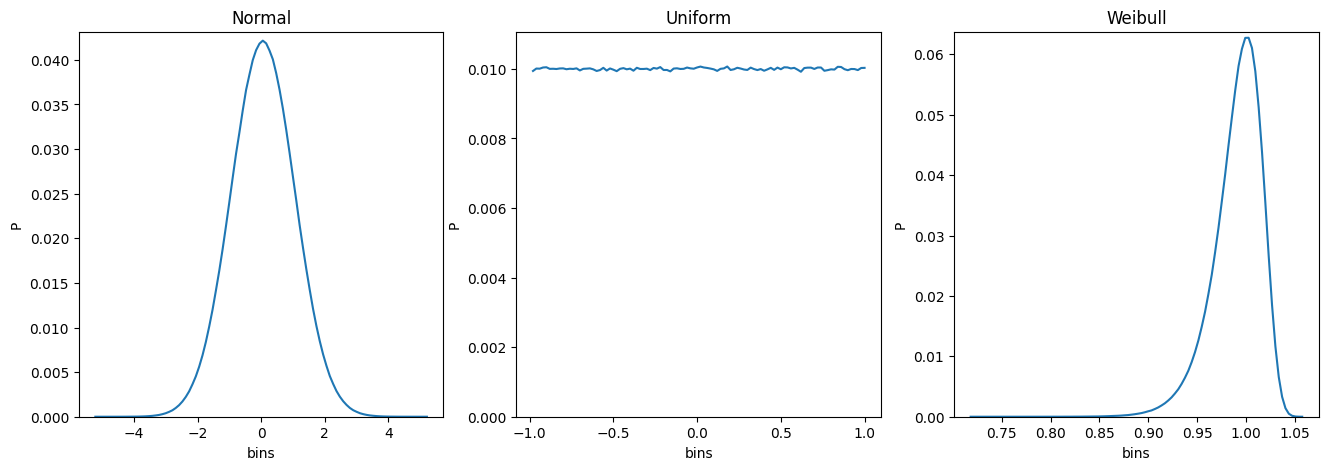

In [2]:
# Distributions
n = 10000000

d_normal , b_normal  = np.histogram(np.random.normal(0, 1, n), bins=100)
d_uniform, b_uniform = np.histogram(np.random.uniform(-1, 1, n), bins=100)
d_weibull, b_weibull = np.histogram(np.random.weibull(50, n), bins=100)

plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.plot(b_normal[1:], d_normal/n)
plt.ylim([0, max(d_normal/n) + 1e-3])
plt.title('Normal')
plt.xlabel('bins'); plt.ylabel('P');

plt.subplot(1,3,2); plt.plot(b_uniform[1:], d_uniform/n)
plt.ylim([0, max(d_uniform/n) + 1e-3])
plt.title('Uniform')
plt.xlabel('bins'); plt.ylabel('P');

plt.subplot(1,3,3); plt.plot(b_weibull[1:], d_weibull/n)
plt.ylim([0, max(d_weibull/n) + 1e-3])
plt.title('Weibull')
plt.xlabel('bins'); plt.ylabel('P');

plt.show()

### Carregando e preparando os dados:

Dataset size: 2997 images
Images shape: torch.Size([3, 64, 64])


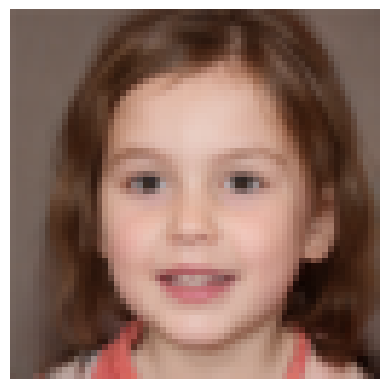

In [3]:
# ==========================
# Hyperparameters
# ==========================
INPUT_SHAPE = 64
BATCH_SIZE = 32
EPOCHS = 100
LEAKY_SLOPE = 0.2
LR = 1e-4
LOSS = nn.BCELoss()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DISTRIBUTION_train = 'normal'
DISTRIBUTION_test  = 'weibull'

broken_files = ['seed111380.png', 'seed111370.png', 'seed111695.png']

# ==========================
# Dataset
# ==========================
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(dataset_dir) if not f.startswith('.') and f not in broken_files ]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.root_dir, fname)
        
        try:
            image = imageio.imread(path).astype(np.float32)
        except Exception as e:
            print(f"Warning: could not read {fname}, skipping. Error: {e}")
            
        image = (image - 127.5) / 127.5  # normalize to [-1, 1]

        # (H, W, C) → (C, H, W)
        image = torch.tensor(image).permute(2, 0, 1)
        image = self.transform(image)
                    
        return image

# ==========================
# Data Loading
# ==========================
dataset_dir = "/kaggle/input/ai-face-dataset-3000-images"  # <--- ajuste para seu path

transform = transforms.Compose([
    transforms.Resize((INPUT_SHAPE, INPUT_SHAPE)),  # resize to INPUT_SHAPExINPUT_SHAPE
])

dataset = ImageFolderDataset(dataset_dir,transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset size: {len(dataset)} images")

# ==========================
# Visualização
# ==========================
def plot_image(img_tensor):
    """Exibe uma imagem normalizada."""
    img = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    img = ((img + 1) * 127.5).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Testar visualização
sample = next(iter(dataloader))[0]
print(f"Images shape: {sample.shape}")
plot_image(sample)

### Criando as redes Gerador e Discriminador

In [15]:
class Generator(nn.Module):
    def __init__(self, input_dim=128, leaky_slope=0.2):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.leaky_slope = leaky_slope

        self.net = nn.Sequential(
            # FC: latent vector → feature map (4x4x1024)
            nn.Linear(input_dim, 1024 * 4 * 4),
            nn.LeakyReLU(leaky_slope, inplace=True),

            # reshape handled in forward()
            
            # 4x4 → 8x8
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(0.1),

            # 8x8 → 16x16
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(0.1),

            # 16x16 → 32x32
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(0.1),

            # 32x32 → 64x64
            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1),
            # nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            # nn.LeakyReLU(leaky_slope, inplace=True),
            # nn.Dropout(0.1),

            # # 64x64 → 128x128
            # nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.net[0](z)  # Linear
        x = self.net[1](x)  # LeakyReLU
        x = x.view(-1, 1024, 4, 4)  # Reshape latent → feature map
        x = self.net[2:](x)  # Pass through ConvTranspose blocks
        return x


# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator(INPUT_SHAPE, LEAKY_SLOPE).to(device)
print(generator)

Generator(
  (net): Sequential(
    (0): Linear(in_features=64, out_features=16384, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): Tanh()
  )
)


In [33]:
# class Discriminator(nn.Module):
#     def __init__(self, leaky_slope=0.2):
#         super(Discriminator, self).__init__()
#         self.leaky_slope = leaky_slope

#         self.net = nn.Sequential(
#             # 128x128x3 → 64x64x64
#             nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(leaky_slope, inplace=True),

#             # 64x64x64 → 32x32x128
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(leaky_slope, inplace=True),

#             # 32x32x128 → 16x16x256
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(leaky_slope, inplace=True),

#             # 16x16x256 → 8x8x512
#             nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(leaky_slope, inplace=True),

#             nn.Flatten(),
#             nn.Linear(512 * 8 * 8, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, leaky_slope=0.2):
        super(Discriminator, self).__init__()
        self.leaky_slope = leaky_slope

        self.net = nn.Sequential(
            # 64x64x3 → 32x32x64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope, inplace=True),

            # 32x32x64 → 16x16x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope, inplace=True),

            # 16x16x128 → 8x8x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope, inplace=True),

            # 8x8x256 → 4x4x512
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(leaky_slope, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


LEAKY_SLOPE = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

discriminator = Discriminator(LEAKY_SLOPE).to(device)
print(discriminator)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=8192, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


### Criando a GAN

In [40]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, z):
        # Generate fake images
        fake_imgs = self.generator(z)
        # Evaluate with discriminator
        validity = self.discriminator(fake_imgs)
        return validity

In [41]:

# Create models
generator = Generator(INPUT_SHAPE, LEAKY_SLOPE).to(device)
discriminator = Discriminator(LEAKY_SLOPE).to(device)

# Loss
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

# Create GAN wrapper (optional)
gan = GAN(generator, discriminator).to(device)

In [42]:
def rand_vector(distribution, size, device="cpu"):
    """
    Generate random latent vectors.
    """
    if distribution == "normal":
        return torch.randn(size, device=device)
    elif distribution == "uniform":
        return (torch.rand(size, device=device) * 2 - 1)
    elif distribution == "weibull":
        q = torch.from_numpy(np.random.weibull(50, size)).float().to(device)
        q = (q - q.mean()) / q.std()
        return q
    else:
        raise ValueError("Specify a valid distribution: normal, uniform, weibull")


def plot_generated_images(id, generator, input_dist, samples=9, dim=(3,3), figsize=(5,5), device="cpu"):
    # Generate latent vectors
    z = rand_vector(input_dist, (samples, INPUT_SHAPE), device=device)
    
    # Generate images
    generator.eval()
    with torch.no_grad():
        generated_images = generator(z)
    
    # Rescale from [-1,1] → [0,255] and convert to numpy
    images = ((generated_images + 1) * 127.5).clamp(0, 255).cpu().numpy().astype('uint8')
    
    # images shape: (samples, 3, 128, 128) → transpose to (samples, 128,128,3)
    images = images.transpose(0, 2, 3, 1)
    
    # Plot
    plt.figure(figsize=figsize)
    for i in range(samples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_dir + f'GAN_image_{id}.png')
    plt.show()

#### Passos de treinamento

Em cada batch:

1. **Treinar o discriminador**

   * Gerar previsões de imagens falsas a partir do gerador
   * A referência é **1 para imagens reais** e **0 para imagens falsas**
   * Treinar o discriminador (**com o gerador congelado**)

2. **Treinar o gerador**

   * Congelar os pesos do discriminador
   * O modelo "gan" produz imagens falsas a partir de ruído aleatório e obtém a saída do discriminador. Treinar o modelo "gan" com o discriminador congelado
   * A referência é **1 para as imagens falsas** (ou seja, enganar o discriminador)


Epoch: 1, Time: 164.76s, g_loss: 1.2546, d_loss: 0.5701


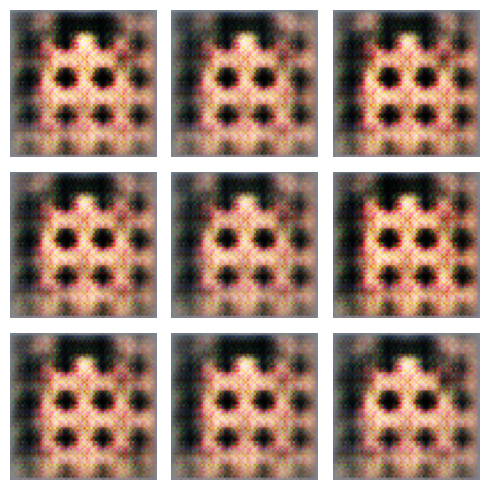

Epoch: 2, Time: 326.17s, g_loss: 1.9264, d_loss: 0.5917
Epoch: 3, Time: 482.06s, g_loss: 0.9636, d_loss: 0.7117
Epoch: 4, Time: 639.09s, g_loss: 1.2909, d_loss: 0.5016
Epoch: 5, Time: 797.00s, g_loss: 1.4823, d_loss: 0.4850
Epoch: 6, Time: 953.94s, g_loss: 1.1330, d_loss: 0.4649
Epoch: 7, Time: 1107.53s, g_loss: 0.7977, d_loss: 0.7020
Epoch: 8, Time: 1261.25s, g_loss: 1.0154, d_loss: 0.6114
Epoch: 9, Time: 1416.34s, g_loss: 0.7439, d_loss: 0.6158
Epoch: 10, Time: 1570.28s, g_loss: 0.9066, d_loss: 0.6277


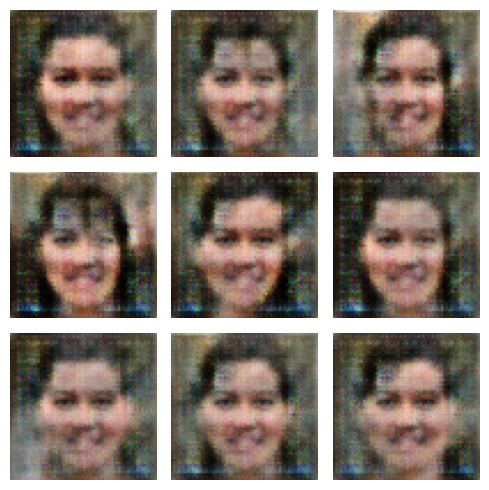

Epoch: 11, Time: 1725.78s, g_loss: 0.8946, d_loss: 0.8050
Epoch: 12, Time: 1878.88s, g_loss: 0.7789, d_loss: 0.6205
Epoch: 13, Time: 2031.52s, g_loss: 0.7595, d_loss: 0.6569
Epoch: 14, Time: 2185.12s, g_loss: 0.9159, d_loss: 0.7060


In [ ]:
output_dir = '/kaggle/working/'
# Ensure output dir exists
os.makedirs(output_dir, exist_ok=True)

d_loss_history = []
g_loss_history = []

start_time = time.time()

for e in range(1, EPOCHS+1):
    for i, real_batch in enumerate(dataloader):
        batch_size = real_batch.size(0)
        real_batch = real_batch.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator.train()
        generator.eval()

        # Labels with random noise (label smoothing)
        real_labels = torch.ones(batch_size, 1, device=device) - 0.05 * torch.rand(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device) + 0.05 * torch.rand(batch_size, 1, device=device)

        # Generate fake images
        z = rand_vector(DISTRIBUTION_train, (batch_size, INPUT_SHAPE), device=device)
        fake_batch = generator(z)

        # Concatenate and shuffle
        all_imgs = torch.cat([real_batch, fake_batch], dim=0)
        all_labels = torch.cat([real_labels, fake_labels], dim=0)
        idx = torch.randperm(all_imgs.size(0))
        all_imgs = all_imgs[idx][:batch_size]
        all_labels = all_labels[idx][:batch_size]

        optimizer_D.zero_grad()
        d_output = discriminator(all_imgs)
        d_loss = criterion(d_output, all_labels)
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        discriminator.eval()
        generator.train()
        for p in discriminator.parameters():
            p.requires_grad = False  # freeze discriminator

        z = rand_vector(DISTRIBUTION_train, (batch_size, INPUT_SHAPE), device=device)
        optimizer_G.zero_grad()
        g_output = discriminator(generator(z))
        g_loss = criterion(g_output, torch.ones(batch_size, 1, device=device))
        g_loss.backward()
        optimizer_G.step()

        for p in discriminator.parameters():
            p.requires_grad = True  # unfreeze

    # Record losses
    d_loss_history.append(d_loss.item())
    g_loss_history.append(g_loss.item())

    # Print epoch info
    print(f"Epoch: {e}, Time: {time.time() - start_time:.2f}s, g_loss: {g_loss.item():.4f}, d_loss: {d_loss.item():.4f}")

    # Plot generated images every 10 epochs
    if e == 1 or e % 10 == 0:
        torch.save(generator.state_dict(), os.path.join(output_dir, f'generator_epoch{e}.pt'))
        torch.save(discriminator.state_dict(), os.path.join(output_dir, f'discriminator_epoch{e}.pt'))
        plot_generated_images(str(e), generator, DISTRIBUTION_train, device=device)

        # Plot learning curves
        plt.figure(figsize=(6,5))
        plt.plot(np.arange(len(d_loss_history)), d_loss_history, color='blue', label='Discriminator')
        plt.plot(np.arange(len(g_loss_history)), g_loss_history, color='red', label='Generator')
        plt.legend()
        plt.grid(True)
        plt.title('Learning curves')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "Learning_curves.png"), dpi=500)
        plt.close()

### Teste

In [ ]:
generator = Generator(INPUT_SHAPE, LEAKY_SLOPE).to(device)
generator.load_state_dict(torch.load(os.path.join(output_dir, 'discriminator_epoch1.pt'), map_location=device))
generator.eval()

In [ ]:
# Generate images with training distribution
plot_generated_images(
    f'Tr_{DISTRIBUTION_train}---Ts_{DISTRIBUTION_train}',
    generator,
    DISTRIBUTION_train,
    samples=16,
    dim=(4,4),
    figsize=(6,6),
    device=device
)

# Generate images with test distribution
plot_generated_images(
    f'Tr_{DISTRIBUTION_train}---Ts_{DISTRIBUTION_test}',
    generator,
    DISTRIBUTION_test,
    samples=16,
    dim=(4,4),
    figsize=(6,6),
    device=device
)

## Tarefa 
Enquanto esperamos o modelo treinar, implemente uma conditional GAN básica em pytorch. Você pode seguir o tutorial "[Rede Adversarial Generativa Condicional
](https://www.geeksforgeeks.org/deep-learning/conditional-generative-adversarial-network/)" (que usa tensorflow). Recomendo usar LLM para ajudar na "tradução" caso caia num impasse.  